# Проведение исследований с моделями классификации

In [1]:
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import random
import matplotlib.pyplot as plt
import torchvision.models as models
import torch
from torch import nn
from functools import partial
from fastai.vision.all import (top_k_accuracy,
                               accuracy,
                               F1Score,
                               Precision,
                               Recall,
                               DataLoaders,
                               CrossEntropyLossFlat,
                               EarlyStoppingCallback,
                               MixUp,
                               Learner)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
img_H = img_W = 224

In [3]:
metrics_list = [
    accuracy,
    partial(top_k_accuracy, k=3),
    partial(top_k_accuracy, k=5),
    F1Score(average='macro'),
    Precision(average='macro'),
    Recall(average='macro')
]

In [4]:
def show_random_images(dataset, num_images=10, denormalize=True,
                       mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """
    Отображает случайные изображения из датасета с их классами.

    Параметры:
      dataset: датасет, возвращающий кортеж (image, label), где image - тензор в формате (C, H, W)
      num_images: количество случайных изображений для отображения
      denormalize: если True, денормализует изображение (требует, чтобы Normalize использовался с указанными mean и std)
      mean, std: параметры нормализации, применяемые к датасету
    """
    indices = random.sample(range(len(dataset)), num_images)

    n_cols = 5
    n_rows = num_images // n_cols + int(num_images % n_cols != 0)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

    if n_rows == 1:
        axs = axs.flatten()
    else:
        axs = [ax for row in axs for ax in row]

    for ax, idx in zip(axs, indices):
        image, label = dataset[idx]
        if denormalize:
            image_denorm = image.clone()
            for t, m, s in zip(image_denorm, mean, std):
                t.mul_(s).add_(m)
            image_denorm = image_denorm.clamp(0, 1)
        else:
            image_denorm = image

        image_np = image_denorm.permute(1, 2, 0).cpu().numpy()
        ax.imshow(image_np)
        ax.set_title(dataset.classes[label])
        ax.axis('off')

    for ax in axs[len(indices):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [5]:
from torch import nn
import torch.nn.functional as F
import torch

class BasicBlock(nn.Module):
    def __init__(self, in_features: int, out_features: int, use_downsample: bool = False):
        super().__init__()
        stride = (2, 2) if use_downsample else (1, 1)

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel_size=(3, 3), stride=stride, padding=(1, 1), bias=False),
            nn.BatchNorm2d(out_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_features, out_features, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(out_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )

        self.use_downsample = use_downsample
        if use_downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_features, out_features, kernel_size=(1, 1), stride=(2, 2), bias=False),
                nn.BatchNorm2d(out_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
        else:
            self.downsample = nn.Identity()

    def forward(self, x):
        identity = x
        out = self.conv_layers(x)
        identity = self.downsample(x)
        out += identity
        return F.relu(out)

class ResNet(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.first = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        )
        self.layer1 = nn.Sequential(
            BasicBlock(64, 64),
            BasicBlock(64, 64)
        )
        self.layer2 = nn.Sequential(
            BasicBlock(64, 128, True),
            BasicBlock(128, 128),
        )
        self.layer3 = nn.Sequential(
            BasicBlock(128, 256, True),
            BasicBlock(256, 256),
        )
        self.layer4 = nn.Sequential(
            BasicBlock(256, 512, True),
            BasicBlock(512, 512),
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)

    def forward(self, x):
        x = self.first(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [5]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size // patch_size, img_size // patch_size)
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

class ViT(nn.Module):
    def __init__(
        self,
        img_size=224,
        patch_size=16,
        in_channels=3,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.,
        num_classes=1000,
        dropout=0.
    ):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            dropout=dropout,
            activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.dropout(x)

        x = x.transpose(0, 1)
        x = self.encoder(x)
        x = x.transpose(0, 1)

        x = self.norm(x)
        cls_out = x[:, 0]
        logits = self.head(cls_out)
        return logits


In [6]:
p = 0.2
train_album = A.Compose([
    A.Resize(img_H, img_W),
    A.Rotate(limit=(0, 90), p=p),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=p),  # случайный поворот на кратные 90 градусов
    A.Transpose(p=p),       # случайная транспозиция
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=p),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=p),
    # Убираем нераспознаваемые аргументы:
    A.GaussNoise(p=p),                # добавление гауссовского шума
    A.RandomFog(p=p),                 # имитация облаков/тумана
    A.RandomSunFlare(p=p),            # эффект блика или солнечного сияния
    A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), p=p),
    A.CoarseDropout(p=p),             # случайное "вытирание" небольших участков
    A.ElasticTransform(p=p),          # эластичное искажение изображения
    # Вместо height и width передаём size
    A.RandomResizedCrop(size=(img_H, img_W), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=p),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

valid_album = A.Compose([
    A.Resize(img_H, img_W),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

def transform_train(pil_image):
    image_np = np.array(pil_image)
    augmented = train_album(image=image_np)
    return augmented['image']

def transform_valid(pil_image):
    image_np = np.array(pil_image)
    augmented = valid_album(image=image_np)
    return augmented['image']

In [12]:
train_ds, valid_ds, test_ds = ImageFolder(root='/kaggle/input/multimedia/PatternNet/train', transform=transform_train),\
                              ImageFolder(root='/kaggle/input/multimedia/PatternNet/validation', transform=transform_valid),\
                              ImageFolder(root='/kaggle/input/multimedia/PatternNet/test', transform=transform_valid)

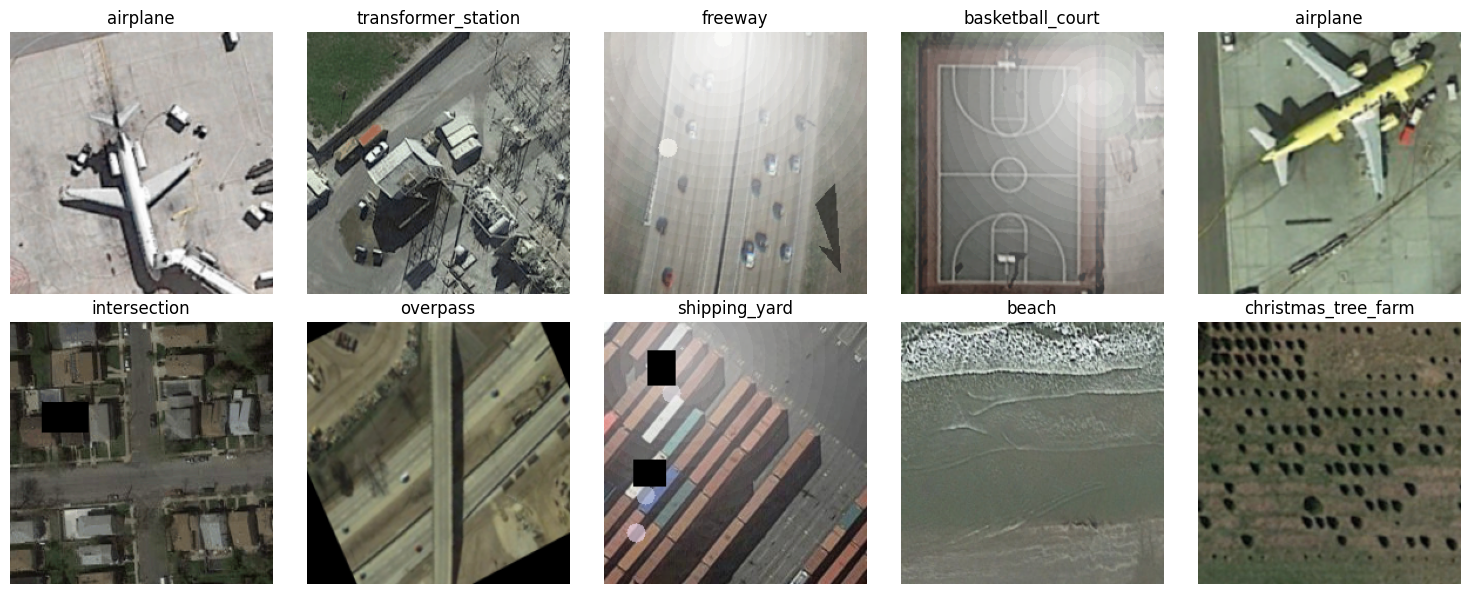

In [9]:
# Отобразить 10 случайных изображений:
show_random_images(train_ds, num_images=10)

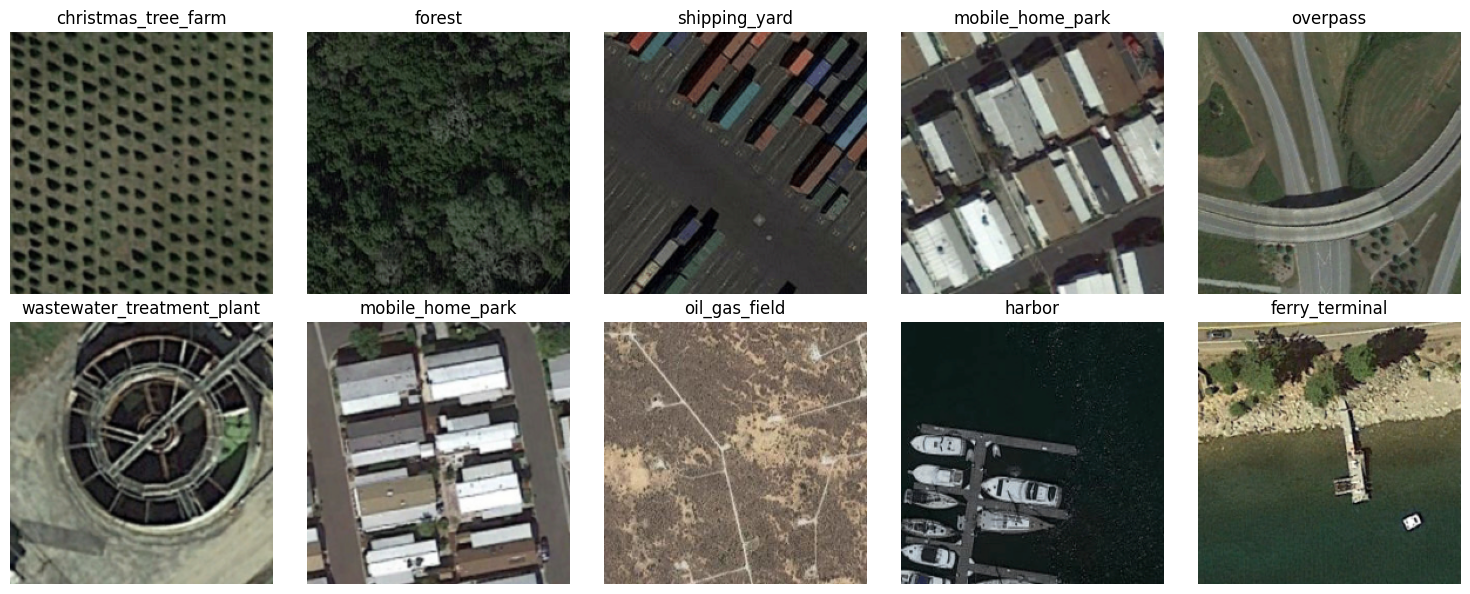

In [10]:
# Отобразить 10 случайных изображений:
show_random_images(valid_ds, num_images=10)

In [11]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, test_ds, bs=16, num_workers=0)
dls = dls.cuda()

In [ ]:
# Сверточная модель: ResNet18
conv_model = ResNet(len(train_ds.classes))
conv_model.to("cuda")

ResNet(
  (first): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv_layers): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (downsample): Identity()
    )
    (1): BasicBlock(
      (conv_layers): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1

In [9]:
loss_func = CrossEntropyLossFlat(label_smoothing=0.1)
early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', patience=2)
mixup_cb = MixUp()

In [14]:
learn = Learner(dls, conv_model, loss_func=loss_func, metrics=metrics_list,
                cbs=[early_stop_cb, mixup_cb])

In [15]:
learn.fit(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,f1_score,precision_score,recall_score,time
0,2.889928,2.228512,0.484868,0.702467,0.810362,0.433475,0.474324,0.484868,06:10
1,2.333430,1.506597,0.741118,0.906579,0.948849,0.730681,0.782595,0.741118,03:53
2,2.094784,1.240716,0.833717,0.955921,0.979441,0.828905,0.856287,0.833717,03:43
3,1.961725,1.147003,0.868750,0.962664,0.983553,0.861507,0.885131,0.868750,03:40
4,1.840702,1.010359,0.916612,0.981250,0.992763,0.913514,0.917865,0.916612,03:42


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
test_dl = dls.test_dl(test_ds)
test_results = learn.validate(dl=test_dl)
print(f"Test results: {test_results}")

Test results: [1.0170429944992065, 0.9103618264198303, 0.9819079041481018, 0.9927631616592407, 0.9071252679297854, 0.9127271259444228, 0.9103618421052632]


In [13]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, test_ds, bs=64, num_workers=0)
dls = dls.cuda()

In [14]:
# Трансформерная модель: Vision Transformer (ViT-B/16)
vit_model = ViT(num_classes=len(train_ds.classes))
vit_model.to("cuda")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ViT(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=768, out_features=38, bias=True)
)

In [15]:
learn = Learner(dls, vit_model, loss_func=loss_func, metrics=metrics_list,
                cbs=[mixup_cb])

In [ ]:
learn.fit(14, 3e-4)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,f1_score,precision_score,recall_score,time
0,3.577888,3.393051,0.082730,0.217599,0.324836,0.025640,0.024244,0.082730,10:20
1,3.541313,3.384807,0.077138,0.212336,0.338487,0.022096,0.029727,0.077138,09:24
2,3.519243,3.344926,0.086842,0.239309,0.375493,0.023430,0.015653,0.086842,09:25
3,3.513606,3.314250,0.093092,0.262664,0.393257,0.036159,0.028854,0.093092,09:29
4,3.520851,3.317643,0.109539,0.274013,0.392105,0.050996,0.042430,0.109539,09:28
5,3.513321,3.328816,0.106086,0.267599,0.393750,0.047127,0.032816,0.106086,09:23
6,3.514692,3.328979,0.103125,0.267270,0.393914,0.038675,0.035162,0.103125,09:34
7,3.521601,3.396882,0.075329,0.228783,0.327138,0.017089,0.009975,0.075329,09:42
8,3.499686,3.293977,0.108882,0.268421,0.393586,0.044555,0.037929,0.108882,09:40


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

In [ ]:
test_dl = dls.test_dl(test_ds)
test_results = learn.validate(dl=test_dl)
print(f"Test results: {test_results}")